In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor


In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")

In [3]:
df.columns = df.columns.str.strip()

In [4]:
columns_to_drop = [ "translation", "CTR clean %","Month","Subject"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [5]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')
df = df.sort_values('Sent_Date').reset_index(drop=True)

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month

In [6]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)

In [7]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

In [8]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})


# Quick check
print(df[cols_to_replace].head())
print(df["Length_Of_subject"].head())

  Personalization Emoji Urgency Tone Price_or_Discount Imperative_Tone Product
0              no   yes      no  yes               yes              no      no
1              no    no      no  yes               yes              no     yes
2              no    no      no   no                no              no     yes
3              no    no     yes  yes                no              no      no
4              no    no      no   no               yes              no     yes
0    short
1    short
2    short
3    short
4    short
Name: Length_Of_subject, dtype: category
Categories (2, object): ['long', 'short']


In [9]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)

print("Outliers in 'Sendings':")
display(outliers['Sendings'])

print("Outliers in 'OR%':")
display(outliers['OR'])

Outliers in 'Sendings':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
707,2024-08-09,Wednesday,NL Interval,MAIN,236976,0.0670,short,no,yes,yes,yes,yes,no,yes,30,August
734,2024-08-16,Wednesday,NL Interval,MAIN,237447,0.0792,short,no,no,yes,yes,yes,yes,yes,28,August
738,2024-08-18,Friday,NL Interval,MAIN,237300,0.0756,short,no,yes,no,yes,yes,no,yes,38,August
749,2024-08-20,Sunday,NL Interval,MAIN,237087,0.0662,short,no,no,yes,yes,yes,yes,yes,24,August
754,2024-08-23,Wednesday,NL Interval,MAIN,237672,0.0655,short,no,no,no,yes,yes,yes,yes,33,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2024-12-22,Friday,NL Interval,MAIN,244071,0.0666,short,no,yes,no,yes,yes,no,yes,38,December
1253,2024-12-24,Sunday,NL Interval,MAIN,243981,0.0678,short,no,no,yes,yes,yes,yes,yes,24,December
1261,2024-12-27,Wednesday,NL Interval,MAIN,244104,0.0699,short,no,no,no,yes,yes,yes,yes,33,December
1268,2024-12-29,Friday,NL Interval,MAIN,243996,0.0667,short,no,no,yes,no,yes,no,yes,28,December


Outliers in 'OR%':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
166,2024-03-01,Wednesday,NL Interval,MAIN,228,0.2763,short,no,no,no,no,no,no,yes,42,March
168,2024-03-01,Wednesday,NL Interval,MAIN,186,0.2742,short,no,no,no,no,yes,no,yes,25,March
169,2024-03-01,Wednesday,NL Interval,MAIN,300,0.3200,short,no,no,no,no,no,no,yes,43,March
226,2024-03-22,Wednesday,NL Interval,MAIN,1188,0.3157,short,no,yes,yes,yes,yes,no,yes,30,March
241,2024-03-29,Wednesday,NL Interval,MAIN,1383,0.2625,short,no,yes,yes,yes,yes,no,yes,30,March
563,2024-07-02,Sunday,NL Interval,MAIN,315,0.2571,short,no,no,no,no,yes,no,yes,25,July
565,2024-07-02,Sunday,NL Interval,MAIN,279,0.2581,short,no,no,no,no,no,no,yes,43,July
680,2024-08-02,Wednesday,NL Interval,MAIN,246,0.2927,short,no,no,no,no,no,no,yes,42,August
899,2024-10-01,Sunday,NL Interval,MAIN,345,0.2957,short,no,yes,no,yes,yes,no,no,26,October
1013,2024-11-01,Wednesday,NL Interval,MAIN,339,0.2566,short,no,yes,no,yes,yes,no,no,26,November


In [10]:
# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling

Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [11]:
TARGET = "OR"
WEIGHT = "Sendings"
DATE_COL = "Sent_Date"


# Define features and target
drop_cols = [TARGET, WEIGHT, DATE_COL]
X = df.drop(columns=drop_cols)
y = df[TARGET]
weights = df[WEIGHT]


In [12]:
cat_cols = [
    'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Personalization',
    'Emoji', 'Urgency', 'Tone', 'Price_or_Discount',
    'Imperative_Tone', 'Product', 'Month'
]
for col in cat_cols:
    X[col] = X[col].astype('category')

In [13]:
# 3. Rolling Time-Series CV setup
# -----------------------------
n_splits = 5  # number of rolling folds
fold_size = len(df) // (n_splits + 1)

results = []

for i in range(n_splits):
    train_end = (i + 1) * fold_size
    test_end = (i + 2) * fold_size if (i + 2) * fold_size < len(df) else len(df)

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    w_train = weights.iloc[:train_end]

    X_test = X.iloc[train_end:test_end]
    y_test = y.iloc[train_end:test_end]
    w_test = weights.iloc[train_end:test_end]

    print(f"\n📆 Fold {i+1}/{n_splits}: Train = {len(X_train)}, Test = {len(X_test)}")


📆 Fold 1/5: Train = 213, Test = 213

📆 Fold 2/5: Train = 426, Test = 213

📆 Fold 3/5: Train = 639, Test = 213

📆 Fold 4/5: Train = 852, Test = 213

📆 Fold 5/5: Train = 1065, Test = 213


In [17]:
    # -----------------------------
    # 4. Train LightGBM model
    # -----------------------------
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        
    )


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 10
[LightGBM] [Info] Start training from score 0.108992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              random_state=42, subsample=0.8)

In [19]:
y_pred = model.predict(X_test)

In [22]:
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    def weighted_mae(y_true, y_pred, weights):
        return np.average(np.abs(y_true - y_pred), weights=weights)

    def weighted_rmse(y_true, y_pred, weights):
        return np.sqrt(np.average((y_true - y_pred)**2, weights=weights))

    w_mae = weighted_mae(y_test, y_pred, w_test)
    w_rmse = weighted_rmse(y_test, y_pred, w_test)

    results.append({
        "Fold": i + 1,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Weighted_MAE": w_mae,
        "Weighted_RMSE": w_rmse
    })

results_df = pd.DataFrame(results)
print("\n📊 Rolling Time-Series Cross-Validation Results:")
print(results_df)

print("\nAverage metrics across folds:")
print(results_df.mean(numeric_only=True))


📊 Rolling Time-Series Cross-Validation Results:
   Fold        R²      MAE      RMSE  Weighted_MAE  Weighted_RMSE
0     5  0.046648  0.02345  0.030905       0.01468       0.022098
1     5  0.046648  0.02345  0.030905       0.01468       0.022098

Average metrics across folds:
Fold             5.000000
R²               0.046648
MAE              0.023450
RMSE             0.030905
Weighted_MAE     0.014680
Weighted_RMSE    0.022098
dtype: float64


In [23]:
# 7. Train final model on all data
# -----------------------------
final_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(
    X, y, sample_weight=weights
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 11
[LightGBM] [Info] Start training from score 0.106869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              random_state=42, subsample=0.8)

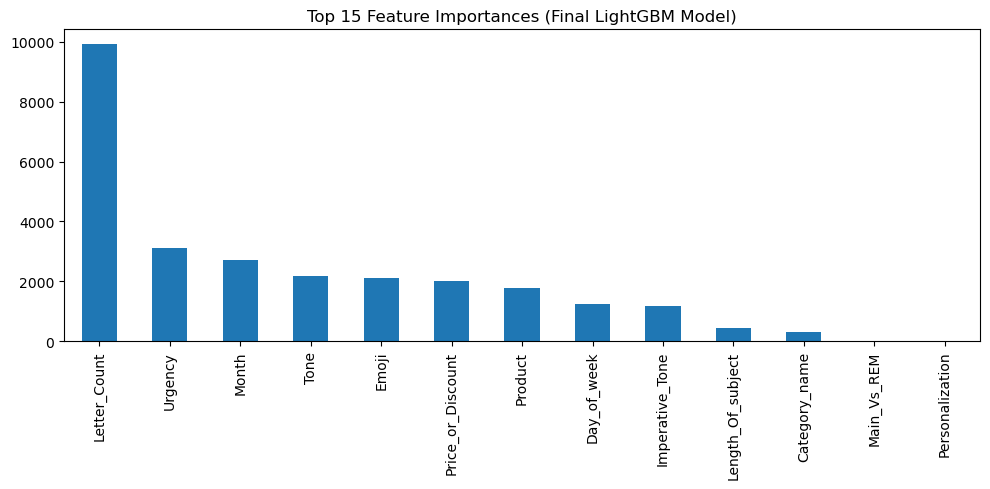

In [24]:
# 8. Feature importance
# -----------------------------
importances = pd.Series(final_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,5))
plt.title("Top 15 Feature Importances (Final LightGBM Model)")
plt.tight_layout()
plt.show()